In [2]:
import numpy as np
import theano
import theano.tensor as T
import network_components
import network_optimizers
from senti_net import network
import cPickle
import time
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from IPython import display
% matplotlib inline

# Load the data

In [3]:
# Load in the data

start = time.time()
with open('./data/ready_data_840B_300d.pkl', 'r') as f:
    data_dict = cPickle.load(f)
    
dur = time.time() - start
print dur

130.204897165


## Plotting functions

In [4]:
# Frequently used plotting functions

def smooth_rep(data,sigma):
    w = np.ceil(2*sigma)
    f = np.exp( -.5*(np.arange(-w,w)**2)/(sigma**2) )
    f = f / np.sum(f)
    
    for rnds in range(3):
        for i in range(len(data)-1):
            if np.isinf(data[i]) or np.isnan(data[i]):
                data[i]=data[i+1]

    y = np.convolve(data,f,'valid')
    x = np.arange(w,len(data)-w+1)
    return x, y


def box_rep(data, sz):
    x = np.arange(float(len(data)))
    x_cs = np.cumsum(x)
    y_cs = np.cumsum(data)
    return (x_cs[sz:] - x_cs[:-sz]) / sz, (y_cs[sz:] - y_cs[:-sz]) / sz


def plot_cost(ax, cost_history, start=0, smooth_sigma=50, max_y = 250., skip=1):
    l = len(cost_history)
    assert l >= start
    c = cost_history[start:]
    
    c = c[::skip]
    l = len(c)
    
    smooth_sigma = np.minimum(smooth_sigma, np.ceil(len(c)/2.))
    
    # Plot the dooder with all the points
    ax[0].cla()
    ax[0].plot(start+(np.arange(l)*skip), c, '.');
    if l > smooth_sigma:
        smth_x, smth_y = box_rep(c, smooth_sigma/skip)
        smth_x = start + (smth_x*skip)
        ax[0].plot(smth_x, smth_y, 'r', linewidth=3)
        
        smooth_sigma = int(smooth_sigma)
        
        max_dat = np.max(c)
        y_cand = np.minimum(max_y, max_dat)
        ax[0].set_ylim([np.maximum(-500,np.min(c)-.2),
                        np.minimum(3000,np.maximum(y_cand, .2+np.max(c[-smooth_sigma:])))])
    else:
        ax[0].set_ylim([np.maximum(-500,np.min(c)-.2),
                        np.minimum(3000,np.minimum(2000, np.max(c)+.2))])
    
    ax[0].grid(axis='y')
    ax[0].set_xlim([start, start+(skip*l)])
    
    # Provide a visualization of just the smoothed one
    if l > smooth_sigma:
        ax[1].cla()
        ax[1].plot(smth_x, smth_y, 'r', linewidth=3)
        xs = [start, start+(skip*l)]
        ax[1].plot(xs,[smth_y[-1], smth_y[-1]], 'k')
        ax[1].set_xlim(xs)
        ax[1].grid(axis='y')
    
    
def plot_pcs(ax_pair_list_or_fig, pc_pairs, labels, ys, n_back=100, cmap='nipy_spectral', bg=.5):
    # pc_pairs must be a list of pairs (where each pair is expressed as a list)
    assert type(pc_pairs) == list
    for pair in pc_pairs:
        assert len(pair)==2
    n_pairs = len(pc_pairs)
    
    if type(ax_pair_list_or_fig) == list:
        # Assume a list of axes, set up in the same way as pc_pairs
        for pair in ax_pair_list_or_fig:
            assert len(pair)==2
        assert len(ax_pair_list_or_fig)==n_pairs
        ax_list = ax_pair_list_or_fig
    else:
        # Assume an empty figure object. Fill it with sub axes to match pc_pairs
        fig = ax_pair_list_or_fig
        ax_list = []
        for i in range(n_pairs):
            ax_list += [[fig.add_subplot(n_pairs, 2, j+1+(2*i)) for j in range(2)]]
    
    if ys.shape[2] > 1:
        # Get your PCs and their projections
        l = labels[:, -n_back:].flatten()
        y = ys[:, :, -n_back:]
        y = np.vstack([y[:,i,:].flatten() for i in range(y.shape[1])])
        eD, eV = np.linalg.eig(np.cov(y))
        eV = eV * np.sign(eV[0,])
        proj = np.dot(eV.T, y)

        # Step through each axis/pc pair and plot them
        cmap = plt.get_cmap(cmap)
        for ax_pc_pair in zip(ax_list, pc_pairs):
            # Unpack
            axs = ax_pc_pair[0]
            pcs = ax_pc_pair[1]
            for ax in axs: ax.cla()
            # Alternately plot the points for each digit
            for i, cidx in enumerate(np.linspace(0, 256, 10)):
                idx = l==i
                axs[(i%2)].plot(proj[pcs[0],idx], proj[pcs[1],idx], '.', c=cmap(int(cidx)), markersize=10);
            # Apply the desired background color
            for ax in axs:
                ax.set_axis_bgcolor(bg*np.ones(3))
            axs[0].set_ylabel("{} vs {}".format(pcs[0], pcs[1]))


def open_scatter(ax, indices, s=160, c='k', w=3):
    return ax.scatter(indices%20, np.floor(indices/20), s=s, edgecolor=c, linewidths=w, facecolor='none')

def plot_acc(ax, acc, eval_interval, start_at=0, xlim=None):
    """
    Plot accuracy
    
    Parameters
    ----------
    ax: matplotlib axis handle
    acc: a list of accuracies, sampled at a consistent interval
    eval_interval: integer, the accuracy sampling interval
    start_at: the earliest time (in training iterations) to display
    xlim: x-axis limit of the plot
    """
    # Figure out the best index to start from
    i_start = int(np.ceil(start_at/float(eval_interval)))
    
    # Trim the data to this interval
    acc_plot = acc[i_start:]
    # Make the appropriate x-data for this
    xdata = (np.arange(i_start, len(acc))+1)*eval_interval
    
    ax.cla()
    ax.plot(xdata, acc_plot, 'o')
    
    if xlim is None:
        xlim = [xdata[0]-eval_interval, xdata[-1]+eval_interval]
    
    if len(acc_plot) >= 2:
        # Apply vanilla linear regression to visualize the trend
        xt = xdata-np.mean(xdata)
        y  = np.array(acc_plot)
        yt = y-np.mean(y)
        r = (yt.dot(xt)) / (xt.dot(xt))
        o = np.mean(y)

        rx = (np.array(xlim)-np.mean(xdata))*r + o
        ax.plot(xlim, rx, 'k-')
    
    ax.grid(axis='y')
    ax.set_xlim(xlim)

# Training routine:

In [5]:
def train_do(network, no_improve_limit, plot_every=10, plot_window=None, smooth_sigma=250):
    if plot_window is None:
        plot_window = no_improve_limit
    
    # Ready the figure
    fig = plt.figure(figsize=(15, 10))
    ax1_2 = [fig.add_subplot(3,1,1), fig.add_subplot(3,1,2)];
    ax3 = fig.add_subplot(3,1,3);
    
    # Apply a number of training rounds
    while network.no_improve_count <= no_improve_limit:

        # Pull data
        i_seq, s_len, t, _ = network.pull_data(data_dict['train'])

        network.adam_helpers(i_seq, s_len, t)
        this_cost = network.adam_train(i_seq, s_len, t)

        # Log
        network.cost_each_step += [this_cost]

        # Check dev accuracy
        if (len(network.cost_each_step) % network.eval_dev_every) == 0:
            this_acc = network.check_accuracy(data_dict['dev'])
            network.dev_acc += [this_acc]
            if this_acc > network.best_dev_acc:
                network.no_improve_count = 0
                network.best_dev_acc = this_acc
                network.best_dev_idx = len(network.cost_each_step)
                network.best_dev_tup = network.snapshot()
            else:
                network.no_improve_count += 1

        # Plot
        start_at = np.maximum(0, len(network.cost_each_step)-plot_window)
        if (len(network.cost_each_step) % plot_every) == 0:
            plot_cost(ax1_2, network.cost_each_step, start=start_at, skip=1, smooth_sigma=250, max_y=1.3)

            plot_acc(ax3, network.dev_acc, network.eval_dev_every, start_at, xlim=ax1_2[0].get_xlim())
            ylim = ax3.get_ylim()
            ax3.plot([network.best_dev_idx, network.best_dev_idx], ylim, 'r-')
            ax3.set_ylim(ylim)

            display.clear_output(wait=True)
            display.display(fig)

    network.end_of_train_tup = network.snapshot()

## Evaluation:

In [6]:
def full_eval(network, baseline_mean, baseline_std):
    # Check performance at the point in training with the best dev performance
    network.restore(network.best_dev_tup)
    print 'At best Dev performance...'
    print '\nTrain accuracy (appoximate): '
    network.check_accuracy(data_dict['train'], 2000);
    print '\nDev accuracy: '
    network.check_accuracy(data_dict['dev']);
    print '\nTest accuracy: '
    network.check_accuracy(data_dict['test']);
    
    # Check the performance at the termination of training
    network.restore(network.end_of_train_tup)
    print '\n\nAt end of training...'
    print '\nTrain accuracy (appoximate): '
    network.check_accuracy(data_dict['train'], 2000);
    print '\nDev accuracy: '
    network.check_accuracy(data_dict['dev']);
    print '\nTest accuracy: '
    a = 100.*network.check_accuracy(data_dict['test']);

    # Compare to the goal
    print '\n\nProbability this score beats Sheng Tai baseline:'
    print '{}%'.format(
        100.*np.round(1000.*np.mean(np.random.normal(baseline_mean, baseline_std, 10000) < a))/1000.)

# 1-layer vanilla LSTM

In [7]:
# Build a 1-layer vanilla LSTM
inp_dim = 300
inp_dropout = 0.5
layer_specs = [(168, 0.5)]

# Build the LSTM "stack"
S = network_components.LSTM_stack(inp_dim, layer_specs, inp_dropout, init_fun=network_components.ortho_weight)
S.initialize_stack_weights(b_f_offset=1.0)
# Add the output sigmoid layer
O = network_components.single_class_sigmoid(S.out_dim)

# Create the network
net_LSTM_1_binary = network(S, O, bi_flag=False, fine_grained=False, batch_size=25, eval_dev_every=50, alpha=0.005)

84.289096117


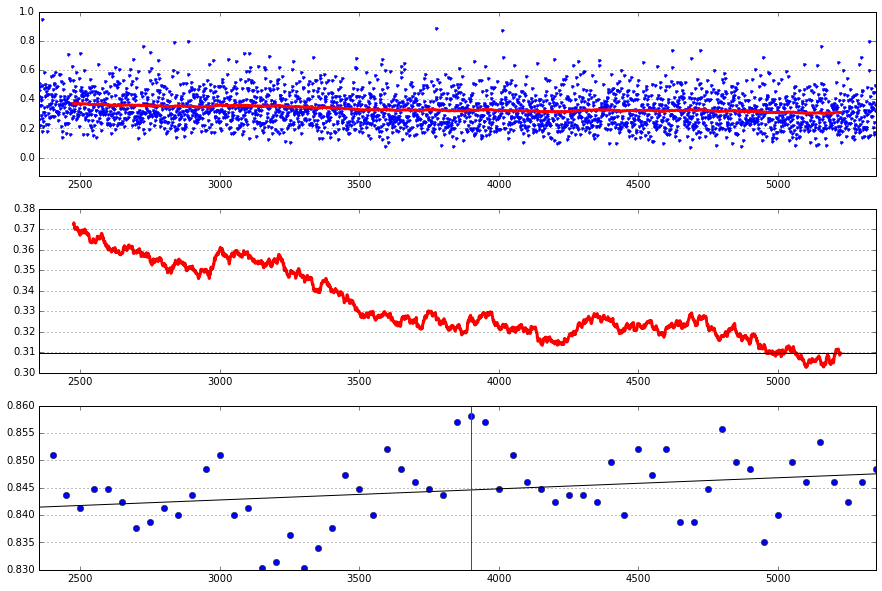

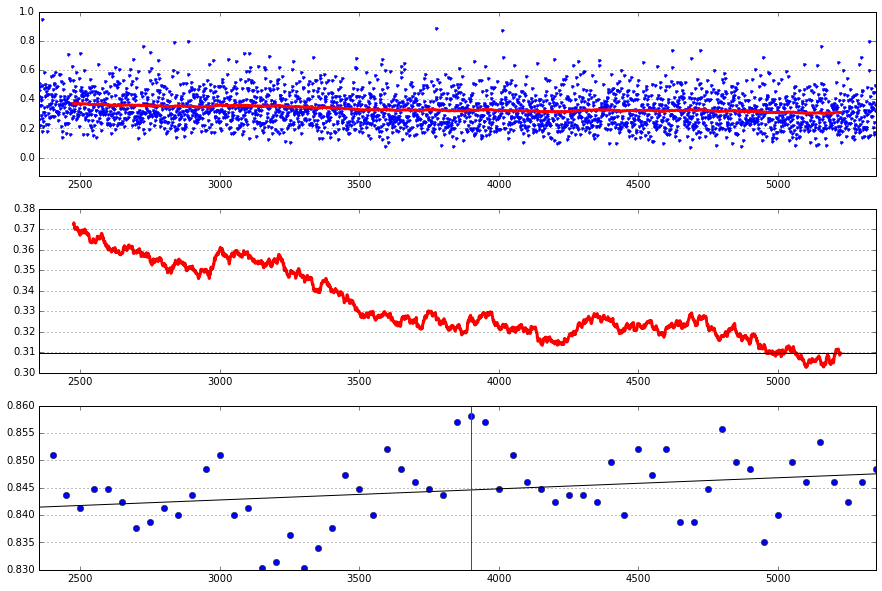

In [8]:
# Train it
train_do(net_LSTM_1_binary, no_improve_limit=28, plot_window=3000)

In [9]:
# See how you did
full_eval(net_LSTM_1_binary, baseline_mean=84.9, baseline_std=0.6)

At best Dev performance...

Train accuracy (appoximate): 
1849/2000, 92.45% correct

Dev accuracy: 
708/825, 85.82% correct

Test accuracy: 
1523/1749, 87.08% correct


At end of training...

Train accuracy (appoximate): 
1905/2000, 95.25% correct

Dev accuracy: 
700/825, 84.85% correct

Test accuracy: 
1514/1749, 86.56% correct


Probability this score beats Sheng Tai baseline:
99.6%


In [208]:
a, b, c, d = net_LSTM_1_binary.pull_data(data_dict['dev'], len(data_dict['dev']))

each_cost = np.zeros(len(b))
for i in range(len(b)):
    each_cost[i] = net_LSTM_1_binary.cfun(a[:, :, :1], b[:1], c[:1])
    a = a[:, :, 1:]
    b = b[1:]
    c = c[1:]
tmp = zip(*[d, each_cost])
tmp.sort(key=lambda x:-x[1])
zip(*tmp)[0]

(768,
 827,
 192,
 322,
 977,
 804,
 43,
 890,
 961,
 547,
 477,
 642,
 445,
 1017,
 830,
 904,
 548,
 769,
 870,
 568,
 809,
 965,
 605,
 615,
 966,
 197,
 421,
 780,
 283,
 109,
 685,
 462,
 1038,
 999,
 915,
 293,
 648,
 971,
 526,
 612,
 266,
 697,
 569,
 218,
 704,
 376,
 645,
 17,
 987,
 985,
 36,
 947,
 362,
 168,
 426,
 463,
 938,
 922,
 593,
 755,
 102,
 614,
 594,
 534,
 691,
 806,
 211,
 752,
 793,
 598,
 694,
 591,
 677,
 1003,
 779,
 260,
 16,
 90,
 240,
 696,
 760,
 296,
 881,
 1028,
 1024,
 958,
 640,
 578,
 831,
 342,
 67,
 595,
 732,
 32,
 849,
 2,
 698,
 29,
 62,
 39,
 886,
 135,
 749,
 935,
 875,
 151,
 657,
 199,
 906,
 655,
 63,
 28,
 536,
 817,
 498,
 573,
 892,
 970,
 975,
 187,
 384,
 689,
 918,
 20,
 882,
 155,
 346,
 361,
 555,
 584,
 853,
 992,
 10,
 888,
 501,
 930,
 523,
 147,
 1029,
 726,
 580,
 172,
 671,
 617,
 148,
 1039,
 530,
 777,
 444,
 887,
 100,
 632,
 364,
 297,
 519,
 184,
 661,
 114,
 776,
 275,
 668,
 125,
 180,
 133,
 1032,
 452,
 709,
 239,


In [212]:
idx = 977
# i_seq, s_len, _, _ = net_LSTM_1_binary.pull_data(data_dict['dev'][np.array([idx, idx])], 1)
i_seq, _ = data_dict['dev'][idx]
i_seq = i_seq[:, :, None]
s_len = np.array([i_seq.shape[0]]).astype('int32')
rev, act_score = data_dict['dev_RT'][idx]
print rev
print act_score
print net_LSTM_1_binary.guess(i_seq, s_len)

Determined to be fun , and bouncy , with energetic musicals , the humor did n't quite engage this adult .
0.36111
[ 0.99284666]


In [213]:
import re
start = 0
rep_seq = i_seq.repeat(s_len, axis=2)[start:][:,:,start:,]
guesses = net_LSTM_1_binary.guess(rep_seq, (np.arange(rep_seq.shape[0])+1).astype('int32'))
s_rev = re.split('\s+', rev)[start:]
for i in range(len(guesses)):
    print '{}\t{}\t{}'.format(i, np.round(100*guesses[i])/100, s_rev[i] )

0	0.69	Determined
1	0.72	to
2	0.62	be
3	0.75	fun
4	0.73	,
5	0.71	and
6	0.9	bouncy
7	0.87	,
8	0.88	with
9	0.95	energetic
10	1.0	musicals
11	0.99	,
12	0.97	the
13	1.0	humor
14	0.99	did
15	0.96	n't
16	0.77	quite
17	0.92	engage
18	0.66	this
19	0.97	adult
20	0.99	.


# 1-layer Bi-Directional LSTM

In [318]:
# Build a 1-layer bi-directional LSTM
inp_dim = 300
inp_dropout = 0.5
layer_specs = [(168, 0.5)]

# Build the LSTM "stack"
S = network_components.BiLSTM_stack(inp_dim, layer_specs, inp_dropout, init_fun=network_components.ortho_weight)
S.initialize_stack_weights(b_f_offset=1.0)
# Add the output sigmoid layer
O = network_components.single_class_sigmoid(S.out_dim)

# Create the network
net_LSTM_1B_binary = network(S, O, bi_flag=True, fine_grained=False, batch_size=25, eval_dev_every=50, alpha=0.001)

40.6659529209


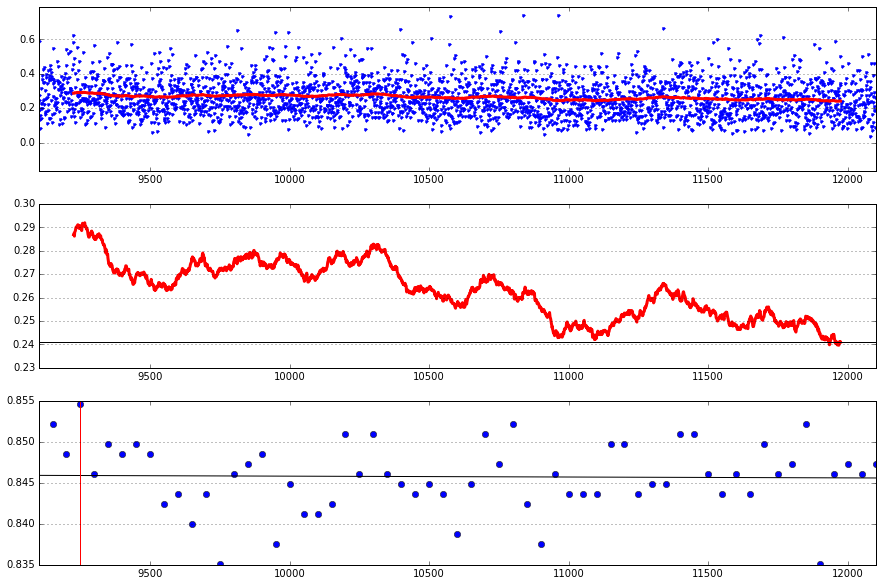

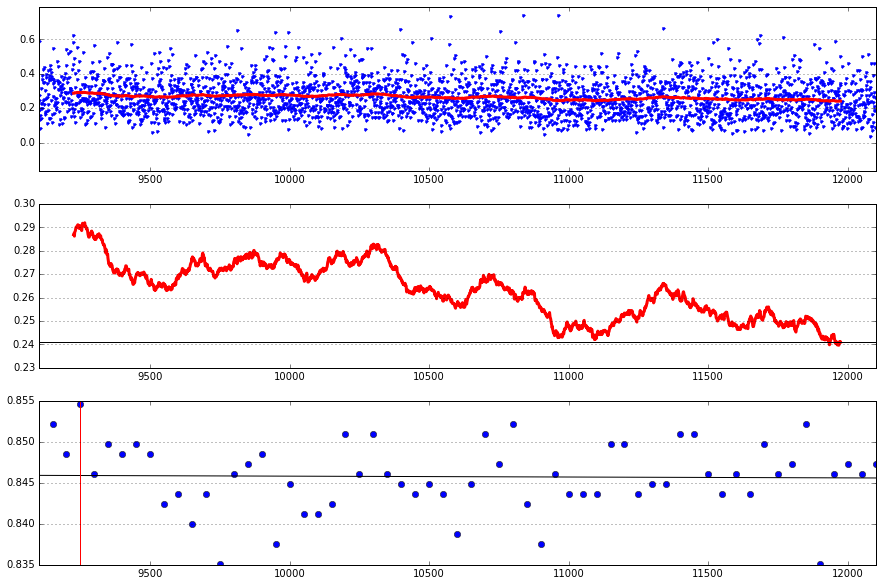

In [321]:
# Train it
train_do(net_LSTM_1B_binary, no_improve_limit=56, plot_window=3000)

In [322]:
# See how you did
full_eval(net_LSTM_1B_binary, baseline_mean=87.5, baseline_std=0.5)

At best Dev performance...

Train accuracy (appoximate): 
1882/2000, 94.1% correct

Dev accuracy: 
705/825, 85.45% correct

Test accuracy: 
1487/1749, 85.02% correct


At end of training...

Train accuracy (appoximate): 
1943/2000, 97.15% correct

Dev accuracy: 
699/825, 84.73% correct

Test accuracy: 
1497/1749, 85.59% correct


Probability this score beats Sheng Tai baseline:
0.0%


# 1-layer vanilla LSTM (Fine-grained)

In [285]:
# Build a 1-layer vanilla LSTM
inp_dim = 300
inp_dropout = 0.5
layer_specs = [(168, 0.5)]

# Build the LSTM "stack"
S = network_components.LSTM_stack(inp_dim, layer_specs, inp_dropout)
S.initialize_stack_weights(b_f_offset=1.0)
# Add the output sigmoid layer
O = network_components.soft_reader(S.out_dim, 5)

# Create the network
net_LSTM_1_fg = network(S, O, bi_flag=False, fine_grained=True, batch_size=25, eval_dev_every=50, alpha=0.005)

18.4299221039


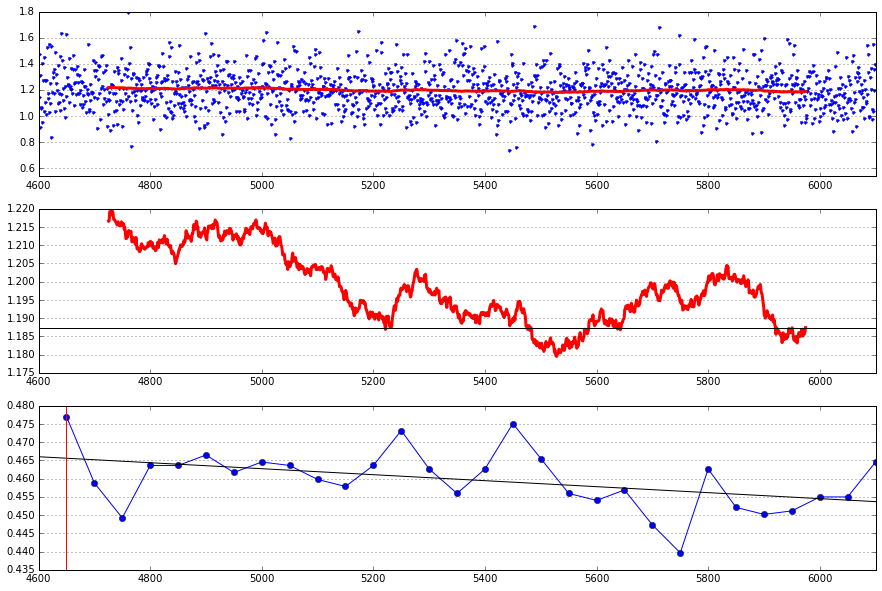

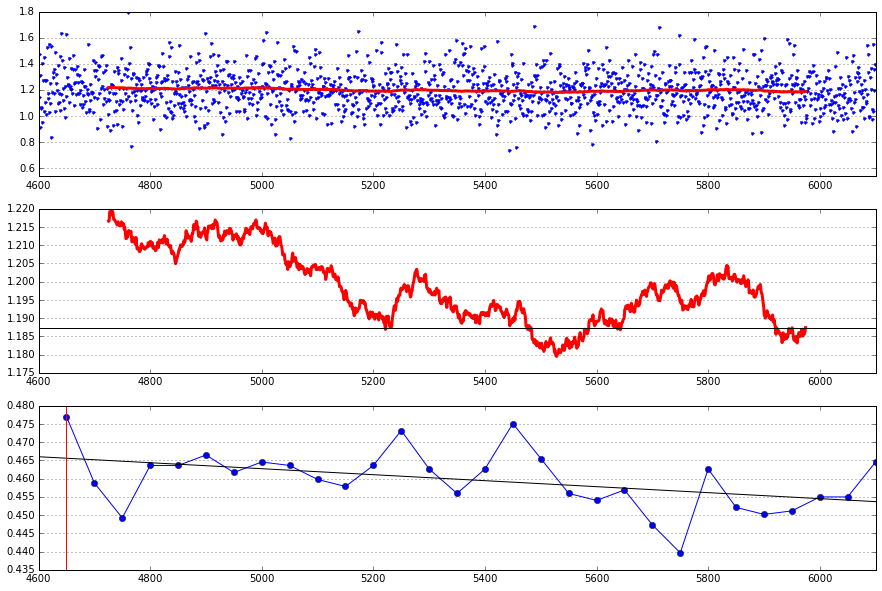

In [286]:
# Train it
train_do(net_LSTM_1_fg, no_improve_limit=28, plot_window=1500)

In [294]:
# See how you did
full_eval(net_LSTM_1_fg, baseline_mean=46.4, baseline_std=1.1)

At best Dev performance...

Train accuracy (appoximate): 
1159/2000, 57.95% correct

Dev accuracy: 
498/1044, 47.7% correct

Test accuracy: 
996/2125, 46.87% correct


At end of training...

Train accuracy (appoximate): 
1206/2000, 60.3% correct

Dev accuracy: 
485/1044, 46.46% correct

Test accuracy: 
1016/2125, 47.81% correct


Probability this score beats Sheng Tai baseline:
90.0%


# 1-layer Bi-directional LSTM (Fine-grained)

In [295]:
# Build a 1-layer vanilla LSTM
inp_dim = 300
inp_dropout = 0.5
layer_specs = [(168, 0.5)]

# Build the LSTM "stack"
S = network_components.BiLSTM_stack(inp_dim, layer_specs, inp_dropout)
S.initialize_stack_weights(b_f_offset=1.0)
# Add the output sigmoid layer
O = network_components.soft_reader(S.out_dim, 5)

# Create the network
net_LSTM_1B_fg = network(S, O, bi_flag=True, fine_grained=True, batch_size=25, eval_dev_every=50, alpha=0.005)

36.1688990593


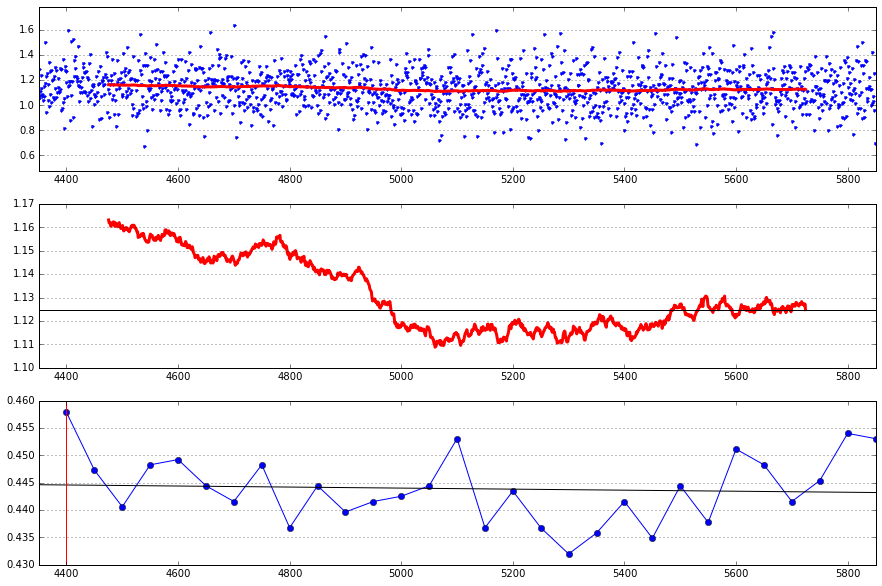

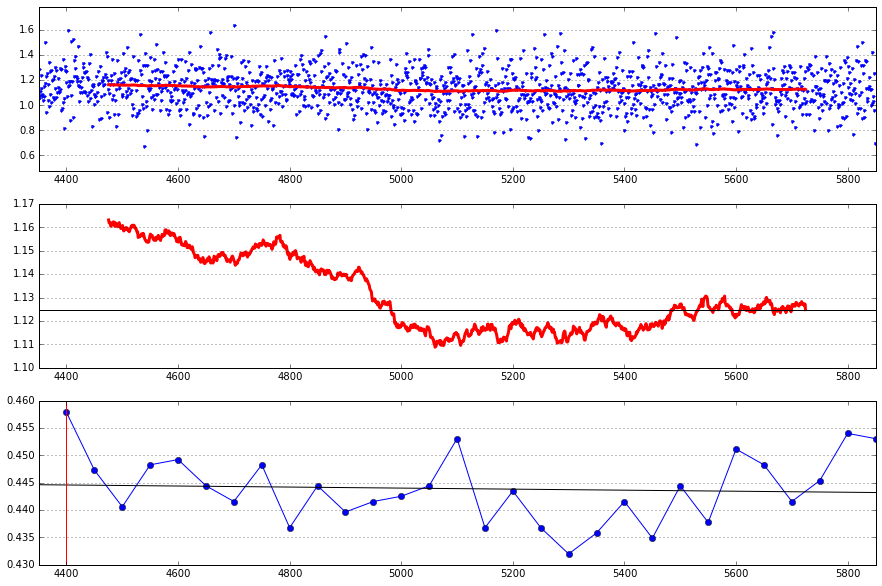

In [296]:
# Train it
train_do(net_LSTM_1B_fg, no_improve_limit=28, plot_window=1500)

In [297]:
# See how you did
full_eval(net_LSTM_1B_fg, baseline_mean=49.1, baseline_std=1.0)

At best Dev performance...

Train accuracy (appoximate): 
1311/2000, 65.55% correct

Dev accuracy: 
478/1044, 45.79% correct

Test accuracy: 
933/2125, 43.91% correct


At end of training...

Train accuracy (appoximate): 
1408/2000, 70.4% correct

Dev accuracy: 
473/1044, 45.31% correct

Test accuracy: 
966/2125, 45.46% correct


Probability this score beats Sheng Tai baseline:
0.0%
